Notebook for computing steady state GNE for the nine species gut microbiome model and analyzing their stability to 
biomass perturbations. Also includes code for generating Figure 3 in the main text, as well as for experiments on 
increasing the supply of inulin and creating Figure 5 in the SI.

In [1]:
import numpy as np
import scipy.io as sio
import scipy.sparse as sparse
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pickle
import main
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
%load_ext autoreload
%autoreload 2



In [2]:
directory = '../ModelFiles/'

# Load and format model files, set parameters for finding GNE.
S = sio.loadmat(directory + 'S.mat')['S']
I = sio.loadmat(directory + 'I.mat')['I'][0][0]
J = sio.loadmat(directory + 'J.mat')['J'][0][0]
reaction_lb = sio.loadmat(directory + 'lb.mat')['lb']
reaction_ub = sio.loadmat(directory + 'ub.mat')['ub']
lumen_reactions_idx = sio.loadmat(directory + 'lumen_reactions_idx.mat')['lumen_uptake_reactions_idx'] - 1
lumen_metabolites_idx = sio.loadmat(directory + 'lumen_metabolites_idx.mat')['lumen_metabolites_idx'] - 1
lumen_reaction_names = sio.loadmat(directory + 'lumen_reactions.mat')['lumen_uptake_reactions']
lumen_reaction_names = np.array([lumen_reaction_names[i][0] for i in range(len(lumen_reaction_names))])
Jl = len(lumen_reactions_idx)
spAbbr = ['Bt', 'Fp', 'Kp', 'St', 'Ba', 'Ec', 'Ef', 'Er', 'Lc']
death_rate = 0.06
max_iters = 5
delta_max = 1
delta_min = 1e-3
C = 5e1
B = 3
sigmoid = lambda x : 1 / (1 + np.exp(-x))
k = np.linspace(0, max_iters, max_iters)
delta_vals = delta_min + (delta_max - delta_min) * sigmoid(k/C - B)


In [3]:
species_params = []
for i in range(9):
    species_params.append({'name':spAbbr[i]})
    species_params[i]['reactions_idx'] = sio.loadmat(directory + spAbbr[i] + '_reactions_idx.mat')[spAbbr[i] + '_reactions_idx'] - 1
    species_params[i]['reaction_names'] = sio.loadmat(directory + spAbbr[i] + '_reactions.mat')[spAbbr[i] + '_reactions']
    species_params[i]['metabolites_idx'] = sio.loadmat(directory + spAbbr[i] + '_metabolites_idx.mat')[spAbbr[i] + '_metabolites_idx'] - 1
    species_params[i]['biomass_idx'] = sio.loadmat(directory + spAbbr[i] + '_biomass_idx.mat')[spAbbr[i] + '_biomass_idx'] - 1
    species_params[i]['I'] = len(species_params[i]['metabolites_idx'])
    species_params[i]['J'] = len(species_params[i]['reactions_idx'])
    species_params[i]['e'] = sparse.identity(species_params[i]['J'] + Jl).tocsr()[:, species_params[i]['biomass_idx'].flatten()]
    

In [ ]:
# This cell block increases the supply of inulin, don't run it if you want results for the baseline/unmodified diet.
print(np.where(lumen_reaction_names == 'UT_inulin(u)')[0][0])
print(reaction_lb[lumen_reactions_idx[360]])
reaction_lb[lumen_reactions_idx[360]] = -0.018


Run the next four cells to create and save steady state GNE. Skip these if you just want to create the figures from the 
paper with steady states that have already been computed.

In [ ]:
# Create many samples of community composition near actual data for the nine species model (not necessary, 
# but speeds up computation of Nash equilibria).
num_starting_points = 100
bm_vals_target = np.array([0.45, 0.3, 0.1, 0.05, 0.02, 0.02, 0.02, 0.02, 0.02])
bm_vals_init = np.maximum(bm_vals_target[:, None] + np.random.uniform(-0.05, 0.05, (9, num_starting_points)), 0.001)
bm_vals_init = np.divide(bm_vals_init, np.sum(bm_vals_init, axis=0)[None,:])
steady_states = []
for i in range(num_starting_points):
    print('Biomass sample ', i)
    output = main.initial_guess(
        bm_vals_init[:,i], species_params, S, Jl, lumen_reactions_idx, death_rate, reaction_lb, reaction_ub
    )
    if (output is None) or (output[0] != 'optimal'):
        continue
    else:
        status = output[0]
        x_vals_init = output[1:]
    num_iters, x_vals_new, bm_vals_new = main.compute_steady_state(
        bm_vals_init[:, i], x_vals_init, max_iters, 1e-6, 1e-6, delta_vals, species_params, S, Jl, lumen_reactions_idx,
        reaction_lb, reaction_ub, death_rate
    )
    if num_iters < max_iters:
        print('New point found')
        x_vals_new = main.initial_guess(
            bm_vals_new, species_params, S, Jl, lumen_reactions_idx, death_rate, reaction_lb, reaction_ub
        )
        if (x_vals_new is None) or (x_vals_new[0] != 'optimal'):
            continue
        steady_states.append((bm_vals_new, x_vals_new[1:]))
    print('\n')


In [ ]:
# Save steady states.
pickle.dump(steady_states, open("steady_states_nine_species.p", "wb"))
# pickle.dump(steady_states, open("steady_states_nine_species_diff_diet.p", "wb"))


In [ ]:
# Compute stability to biomass perturbations.
stable_steady_states = []
unstable_steady_states = []
for i in range(len(steady_states)):
    print('Checking stability of steady state ', i)
    bm_vals, x_vals = steady_states[i]
    try:
        pert_size = 1e-9
        feas_tol = 1e-2
        stable, max_eig, _ = main.stability(
            bm_vals, x_vals, pert_size, species_params, S, Jl, reaction_lb,
            reaction_ub, lumen_reactions_idx, lumen_metabolites_idx, feas_tol)
    except:
        continue
    
    if stable:
        stable_steady_states.append((bm_vals, x_vals, max_eig))
    else:
        unstable_steady_states.append((bm_vals, x_vals, max_eig))


In [ ]:
pickle.dump(unstable_steady_states, open("unstable_steady_states.p", "wb"))
pickle.dump(stable_steady_states, open("stable_steady_states.p", "wb"))
# pickle.dump(unstable_steady_states, open("unstable_steady_states_nine_species.p", "wb"))
# pickle.dump(stable_steady_states, open("stable_steady_states_nine_species.p", "wb"))


Now make figures from the paper.

In [5]:
unstable_ss = pickle.load(open('unstable_steady_states_nine_species.p', 'rb'))
stable_ss = pickle.load(open('stable_steady_states_nine_species.p', 'rb'))
unstable_ss_new = pickle.load(open('unstable_steady_states_nine_species_diff_diet.p', 'rb'))
stable_ss_new = pickle.load(open('stable_steady_states_nine_species_diff_diet.p', 'rb'))

In [6]:
stable_ss1_bm = stable_ss[0][0]
stable_ss2_bm = stable_ss[1][0]

stable_ss1_bm_new = stable_ss_new[0][0]
stable_ss2_bm_new = stable_ss_new[1][0]

stable_ss1_bm_phyla = [stable_ss1_bm[0],
                      stable_ss1_bm[7]+stable_ss1_bm[1]+stable_ss1_bm[6]+stable_ss1_bm[8]+stable_ss1_bm[3],
                      stable_ss1_bm[4],
                      stable_ss1_bm[5]+stable_ss1_bm[2],
                      stable_ss1_bm[7]+stable_ss1_bm[1],
                      stable_ss1_bm[6]+stable_ss1_bm[8]+stable_ss1_bm[3]]

stable_ss2_bm_phyla = [stable_ss2_bm[0],
                      stable_ss2_bm[7]+stable_ss2_bm[1]+stable_ss2_bm[6]+stable_ss2_bm[8]+stable_ss2_bm[3],
                      stable_ss2_bm[4],
                      stable_ss2_bm[5]+stable_ss2_bm[2],
                      stable_ss2_bm[7]+stable_ss2_bm[1],
                      stable_ss2_bm[6]+stable_ss2_bm[8]+stable_ss2_bm[3]]

stable_ss1_bm_phyla_new = [stable_ss1_bm_new[0],
                      stable_ss1_bm_new[7]+stable_ss1_bm_new[1]+stable_ss1_bm_new[6]+stable_ss1_bm_new[8]+stable_ss1_bm_new[3],
                      stable_ss1_bm_new[4],
                      stable_ss1_bm_new[5]+stable_ss1_bm_new[2],
                      stable_ss1_bm_new[7]+stable_ss1_bm_new[1],
                      stable_ss1_bm_new[6]+stable_ss1_bm_new[8]+stable_ss1_bm_new[3]]

stable_ss2_bm_phyla_new = [stable_ss2_bm_new[0],
                      stable_ss2_bm_new[7]+stable_ss2_bm_new[1]+stable_ss2_bm_new[6]+stable_ss2_bm_new[8]+stable_ss2_bm_new[3],
                      stable_ss2_bm_new[4],
                      stable_ss2_bm_new[5]+stable_ss2_bm_new[2],
                      stable_ss2_bm_new[7]+stable_ss2_bm_new[1],
                      stable_ss2_bm_new[6]+stable_ss2_bm_new[8]+stable_ss2_bm_new[3]]


In [7]:
ss1_new_rel_diff = [
    100 * (stable_ss1_bm_new[0] - stable_ss1_bm[0]) / stable_ss1_bm[0],
    100 * ((stable_ss1_bm_new[7] + stable_ss1_bm_new[1] + stable_ss1_bm_new[6] + stable_ss1_bm_new[8] + stable_ss1_bm_new[3]) - (stable_ss1_bm[7] + stable_ss1_bm[1] + stable_ss1_bm[6] + stable_ss1_bm[8] + stable_ss1_bm[3])) / (stable_ss1_bm[7] + stable_ss1_bm[1] + stable_ss1_bm[6] + stable_ss1_bm[8] + stable_ss1_bm[3]),
    100 * (stable_ss1_bm_new[4] - stable_ss1_bm[4]) / stable_ss1_bm[4],
    100 * ((stable_ss1_bm_new[5] + stable_ss1_bm_new[2]) - (stable_ss1_bm[5] + stable_ss1_bm[2])) / (stable_ss1_bm[5] + stable_ss1_bm[2]),
    100 * ((stable_ss1_bm_new[7] + stable_ss1_bm_new[1]) - (stable_ss1_bm[7] + stable_ss1_bm[1])) / (stable_ss1_bm[7] + stable_ss1_bm[1]),
    100 * ((stable_ss1_bm_new[6] + stable_ss1_bm_new[8] + stable_ss1_bm_new[3]) - (stable_ss1_bm[6] + stable_ss1_bm[8] + stable_ss1_bm[3])) / (stable_ss1_bm[6] + stable_ss1_bm[8] + stable_ss1_bm[3])
]
ss2_new_rel_diff = [
    100 * (stable_ss2_bm_new[0] - stable_ss1_bm[0]) / stable_ss1_bm[0],
    100 * ((stable_ss2_bm_new[7] + stable_ss2_bm_new[1] + stable_ss2_bm_new[6] + stable_ss2_bm_new[8] + stable_ss2_bm_new[3]) - (stable_ss1_bm[7] + stable_ss1_bm[1] + stable_ss1_bm[6] + stable_ss1_bm[8] + stable_ss1_bm[3])) / (stable_ss1_bm[7] + stable_ss1_bm[1] + stable_ss1_bm[6] + stable_ss1_bm[8] + stable_ss1_bm[3]),
    100 * (stable_ss2_bm_new[4] - stable_ss1_bm[4]) / stable_ss1_bm[4],
    100 * ((stable_ss2_bm_new[5] + stable_ss2_bm_new[2]) - (stable_ss1_bm[5] + stable_ss1_bm[2])) / (stable_ss1_bm[5] + stable_ss1_bm[2]),
    100 * ((stable_ss2_bm_new[7] + stable_ss2_bm_new[1]) - (stable_ss1_bm[7] + stable_ss1_bm[1])) / (stable_ss1_bm[7] + stable_ss1_bm[1]),
    100 * ((stable_ss2_bm_new[6] + stable_ss2_bm_new[8] + stable_ss2_bm_new[3]) - (stable_ss1_bm[6] + stable_ss1_bm[8] + stable_ss1_bm[3])) / (stable_ss1_bm[6] + stable_ss1_bm[8] + stable_ss1_bm[3])
]


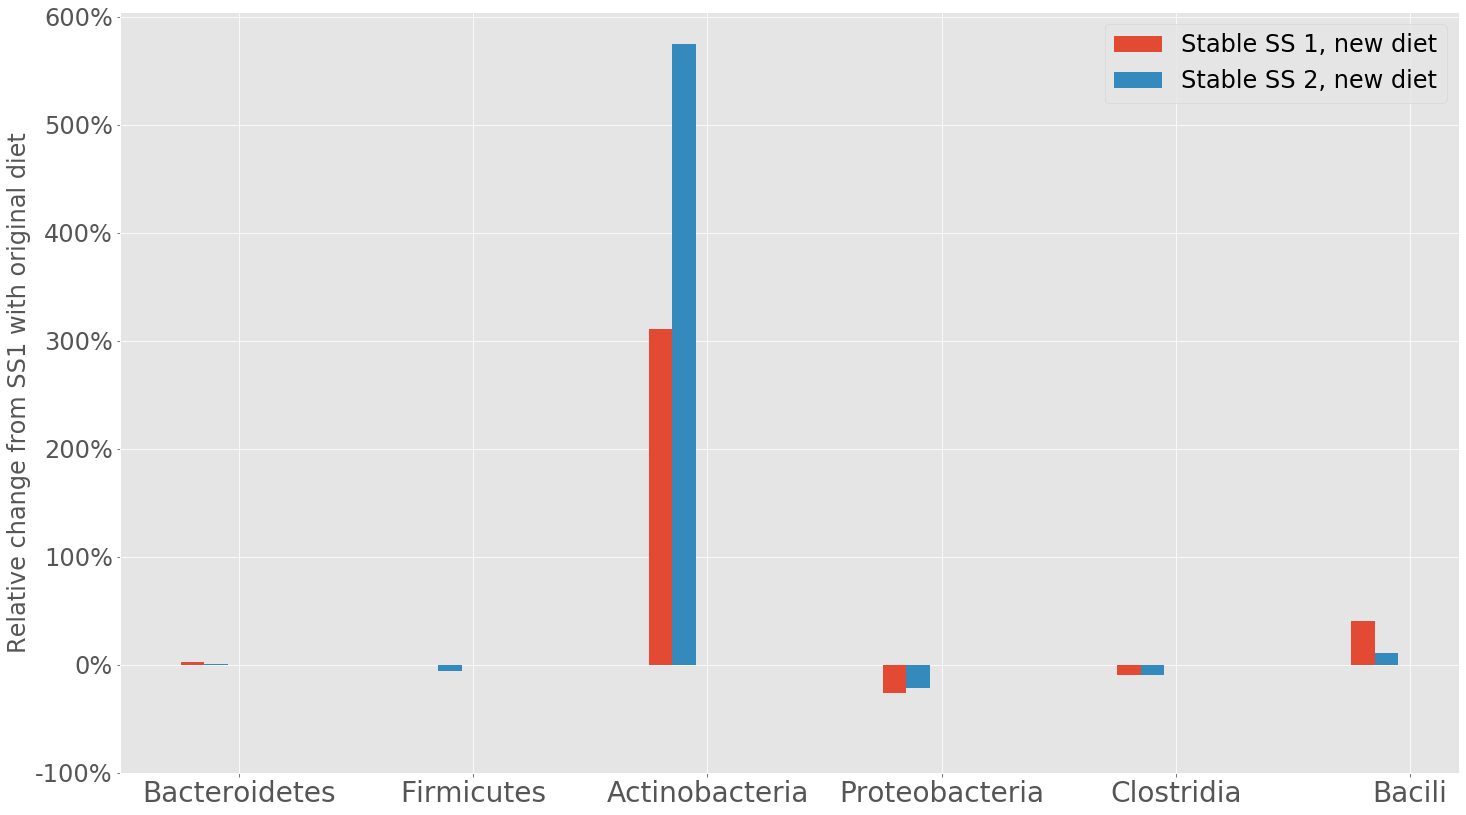

In [8]:
phyla = ['Bacteroidetes', 'Firmicutes', 'Actinobacteria', 'Proteobacteria', 'Clostridia', 'Bacili']
barWidth = 0.2
fig = plt.subplots(figsize = (24, 14))

br1 = 2*np.arange(6)
br2 = [x + barWidth for x in br1]

plt.bar(br1, ss1_new_rel_diff, width = barWidth, label = 'Stable SS 1, new diet')
plt.bar(br2, ss2_new_rel_diff, width = barWidth, label = 'Stable SS 2, new diet')

plt.ylabel('Relative change from SS1 with original diet', fontsize = 24)
plt.xticks([r + 2*barWidth for r in 2*np.arange(6)], phyla, fontsize = 28)
plt.yticks([-100, 0, 100, 200, 300, 400, 500, 600], ['-100%', '0%', '100%', '200%', '300%', '400%', '500%', '600%'], fontsize = 24)

plt.legend(loc = 'best', fontsize = 24)
# plt.savefig('nine_species_new_diet.png')
plt.show()

In [10]:
steadycom_bm = sio.loadmat('../SteadyCom/biomasses.mat')['biomass']
steadycom_bm_phyla = [steadycom_bm[0][0],
                    steadycom_bm[7][0]+steadycom_bm[1][0]+steadycom_bm[6][0]+steadycom_bm[8][0]+steadycom_bm[3][0],
                    steadycom_bm[4][0],
                    steadycom_bm[5][0]+steadycom_bm[2][0],
                    steadycom_bm[7][0]+steadycom_bm[1][0],
                    steadycom_bm[6][0]+steadycom_bm[8][0]+steadycom_bm[3][0]]
steadycom_bm_phyla_paper_approx = [0.45, 0.5, 0.02, 0.03, 0.40, 0.1]
experiment1_bm_phyla_approx = [0.675, 0.29, 0.03, 0.005, 0.285, 0.005]
experiment2_bm_phyla_approx = [0.35, 0.62, 0.02, 0.01, 0.6, 0.02]


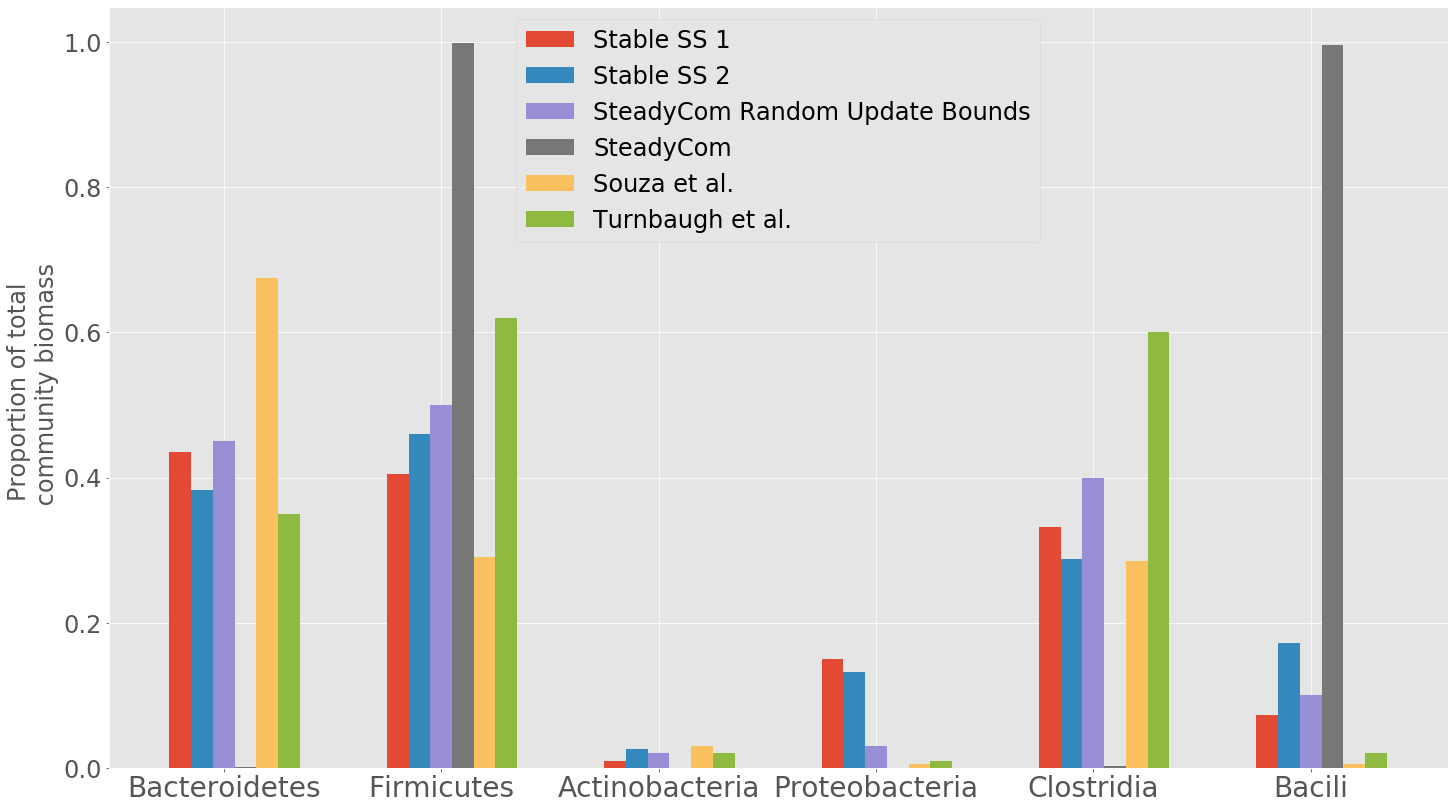

In [11]:
phyla = ['Bacteroidetes', 'Firmicutes', 'Actinobacteria', 'Proteobacteria',
        'Clostridia', 'Bacili']
barWidth = 0.2
fig = plt.subplots(figsize = (24, 14))

br1 = 2*np.arange(6)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]

plt.bar(br1, stable_ss1_bm_phyla, width = barWidth, 
        label = 'Stable SS 1')
plt.bar(br2, stable_ss2_bm_phyla, width = barWidth,
        label = 'Stable SS 2')
plt.bar(br3, steadycom_bm_phyla_paper_approx, width = barWidth,
        label = 'SteadyCom Random Update Bounds')
plt.bar(br4, steadycom_bm_phyla, width = barWidth,
        label = 'SteadyCom')
plt.bar(br5, experiment1_bm_phyla_approx,
        width = barWidth, label = 'Souza et al.')
plt.bar(br6, experiment2_bm_phyla_approx,
        width = barWidth, label = 'Turnbaugh et al.')

plt.ylabel('Proportion of total \n community biomass', fontsize = 24)
plt.xticks([r + 2*barWidth for r in 2*np.arange(6)], phyla, fontsize = 28)
plt.yticks(fontsize = 24)

plt.legend(loc = 'best', fontsize = 24)
# plt.savefig('nine_species_comparison.png')
plt.show()
